In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from importHelpers.response import *
from mlxtend.preprocessing import minmax_scaling
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

#### clean

In [2]:
xls = pd.ExcelFile(r'data\\191126P2_ROIAnnotationSummary_200218.xlsx')
df = pd.read_excel(xls, 'Annotation_Summary')
df = df[['Flash', '2P ROI', 'RBPMS', 'Syt10+', 'Syt6+', 'CAVIII', 'ChAT', 'Satb2', 'MEIS', 'CalR']]
df = df.dropna(axis = 0, subset = ["2P ROI"])
df = df[df['2P ROI'].apply(lambda x: str(x).isdigit())]
df = df.astype({"2P ROI": int})
for col in ['Syt10+', 'Syt6+', 'CAVIII', 'ChAT', 'Satb2', 'MEIS', 'CalR']:
    df[col] = df[col].apply(lambda x: int(not pd.isna(x)))

In [3]:
l = list(df.T)
def name_merge(x):
    p = [str(i[l[x]]) for _, i in df.loc[[l[x]]].to_dict().items()]
    return p[0] + '_wave_' + str(p[1])
name_merge(0)

def uniquer(x):
    return "".join([str(i[l[x]]) for _, i in df.loc[[l[x]]].to_dict().items()][2:])

d = {}
c = 0
z = []
for i in range(df.shape[0]):
    u = uniquer(i)
    if u not in d.keys():
        d[u] = c
        c += 1
    z.append(d[u])
df.insert(10, "Class", z)

s = []
for i in range(df.shape[0]):
    s.append(name_merge(i))

#### combine

In [4]:
# FILENAME
xlsx_filename = "data\\191126P2PhysData_withlabels.xlsx"
excel = pd.ExcelFile(xlsx_filename)

def renamer(sheet, ind):
    l = lambda name: str(ind) + '_' + name
    sheet = sheet.rename(index = l)
    return sheet
i = 0
new_sheetnames = ['Flash_40', 'Flash_52', 'Flash_56', 'Flash_58', 'Flash_60', 'Flash_66', 'Flash_68', 'Flash_46']
total = renamer(pd.read_excel(xlsx_filename,sheet_name=excel.sheet_names[i], header=0).T, new_sheetnames[0])
for i in range(1, len(excel.sheet_names)):
    print('Working on sheet ' + str(i + 1) + ' of ' + str(len(excel.sheet_names)))
    total = total.append(renamer(pd.read_excel(xlsx_filename,sheet_name=excel.sheet_names[i], header=0).T, new_sheetnames[i]))
print("Sheet combination complete.")
n = total

Working on sheet 2 of 8
Working on sheet 3 of 8
Working on sheet 4 of 8
Working on sheet 5 of 8
Working on sheet 6 of 8
Working on sheet 7 of 8
Working on sheet 8 of 8
Sheet combination complete.


In [5]:
n = n[[i in s for i in n.index]]
n

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Flash_40_wave_1,-0.282811,0.832223,1.571895,1.511685,1.777528,2.218740,2.128655,1.977111,2.087082,2.107779,...,2.047339,2.123366,1.872845,2.199981,2.028838,2.053396,2.005515,2.070698,1.913456,1.785120
Flash_40_wave_2,0.571081,0.494429,0.751718,0.580546,0.632446,0.855266,0.680370,0.764025,0.453674,0.620698,...,0.516698,0.785411,0.556864,0.525525,0.621531,0.685788,0.578357,0.565160,0.614412,0.469929
Flash_40_wave_3,2.096727,3.333588,3.859820,4.164157,4.005630,4.153227,4.078456,3.821792,3.855679,3.537391,...,4.618674,4.476266,4.738743,4.588993,4.546078,4.538284,4.452612,4.481684,4.693524,4.886218
Flash_40_wave_4,0.281441,0.346466,0.693288,0.877922,0.841007,0.955635,1.120212,1.092848,1.156230,1.256585,...,1.031648,0.785741,0.998500,0.974495,0.936173,0.851405,0.943852,0.935190,0.879609,0.934099
Flash_40_wave_5,0.578530,1.201865,1.635306,1.709711,1.883825,1.952654,1.961918,2.008558,1.999788,2.141422,...,1.150016,0.960056,1.104510,0.978815,0.958205,0.997115,1.030643,1.107826,0.940766,1.002950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Flash_46_wave_59,3.514678,4.924971,5.835104,6.257974,6.559562,6.262323,6.273296,6.150227,6.417154,6.272162,...,4.959475,5.125802,5.191646,5.029380,5.086942,5.264967,5.195457,5.340018,5.472021,5.607791
Flash_46_wave_65,2.334159,2.937608,2.372215,2.007245,1.645733,1.116064,0.814676,1.469086,1.106885,1.502549,...,0.952743,0.747290,0.905035,0.744348,0.933812,0.672914,0.545547,0.528410,0.571942,0.361723
Flash_46_wave_76,5.914798,7.498043,7.846637,7.547990,7.341963,7.228784,7.064824,7.246309,7.724882,7.847785,...,5.629679,5.542924,5.973587,5.648575,5.370740,5.610396,5.612535,5.962801,5.818900,5.763261
Flash_46_wave_86,0.569609,1.132857,1.210412,1.188244,1.100053,1.046596,0.846080,0.704067,0.861538,0.743415,...,0.876272,1.013606,1.181771,1.193820,0.839227,0.850917,0.906549,0.899229,1.125085,1.173561


In [6]:
list(n.index)

['Flash_40_wave_1',
 'Flash_40_wave_2',
 'Flash_40_wave_3',
 'Flash_40_wave_4',
 'Flash_40_wave_5',
 'Flash_40_wave_6',
 'Flash_40_wave_7',
 'Flash_40_wave_8',
 'Flash_40_wave_9',
 'Flash_40_wave_10',
 'Flash_40_wave_11',
 'Flash_40_wave_12',
 'Flash_40_wave_13',
 'Flash_40_wave_14',
 'Flash_40_wave_15',
 'Flash_40_wave_16',
 'Flash_40_wave_17',
 'Flash_40_wave_18',
 'Flash_40_wave_19',
 'Flash_40_wave_20',
 'Flash_40_wave_21',
 'Flash_40_wave_22',
 'Flash_40_wave_23',
 'Flash_40_wave_24',
 'Flash_40_wave_25',
 'Flash_40_wave_26',
 'Flash_40_wave_27',
 'Flash_40_wave_28',
 'Flash_40_wave_29',
 'Flash_40_wave_30',
 'Flash_40_wave_31',
 'Flash_40_wave_32',
 'Flash_40_wave_33',
 'Flash_40_wave_34',
 'Flash_40_wave_35',
 'Flash_40_wave_37',
 'Flash_40_wave_38',
 'Flash_40_wave_39',
 'Flash_40_wave_40',
 'Flash_40_wave_41',
 'Flash_40_wave_42',
 'Flash_40_wave_43',
 'Flash_40_wave_44',
 'Flash_40_wave_45',
 'Flash_40_wave_46',
 'Flash_40_wave_47',
 'Flash_40_wave_48',
 'Flash_40_wave_49',
 

In [7]:
def getClassByName(name):
    return z[s.index(name)]

In [8]:
n_class = []
for name in list(n.index):
    n_class.append(getClassByName(name))

In [9]:
len(n_class)

603

In [10]:
def transform(initial):
    # remove and subtract baseline
    # c = frameToSecDF(initial.sub(initial['baseline'], axis = 'rows').drop('baseline', axis = 1).T)
    # drop 70
    c = initial
    a = [a - b > 70 for a, b in zip(list(c.max(axis = 1)), list(c.min(axis= 0)))]
    dropped = []
    for i in range(len(a)):
        if not a[i]:
            dropped.append(list(c.T)[i])
    c = c.drop(dropped, axis = 0)
    # -1 1 scale
    last = c[c.columns[-15:]]
    last = last.mean(axis=1)
    ne = c.sub(last, axis = 0)
    n_one = ne.div(ne.abs().max(axis = 1), axis = 0)
    return n_one

In [11]:
#n = df
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(n)
principalDf = pd.DataFrame(data = principalComponents)
pca_n = pd.DataFrame(data = pca.inverse_transform(principalComponents))
pca_n = pca_n.rename(index={a:b for a,b in zip(range(len(list(n.T))),list(n.T))}, columns={a:b for a,b in zip(range(len(list(n))),list(n))})
# comment next line for no PCA
n = pca_n

In [12]:
db = DBSCAN(eps=3, min_samples=2).fit(n)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
dlabels = db.labels_
print("DBSCAN with your params found:")
print(str(max(dlabels + 1)) + " classified labels")
print(str(list(dlabels).count(-1)) + ' unclassified points out of ' + str(len(dlabels)))

DBSCAN with your params found:
21 classified labels
107 unclassified points out of 603


In [13]:
#n.insert(200, "Class", n_class)

In [14]:
dlabels[0]

-1

In [15]:
n_class

[2,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 2,
 3,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 4,
 2,
 1,
 1,
 4,
 1,
 11,
 1,
 0,
 1,
 1,
 7,
 4,
 1,
 3,
 2,
 8,
 1,
 1,
 1,
 11,
 1,
 1,
 12,
 1,
 1,
 10,
 3,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 3,
 1,
 5,
 6,
 1,
 1,
 1,
 1,
 1,
 3,
 10,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 9,
 0,
 10,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 2,
 5,
 1,
 5,
 1,
 10,
 1,
 1,
 1,
 1,
 1,
 10,
 1,
 4,
 0,
 1,
 5,
 4,
 4,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 9,
 1,
 4,
 0,
 4,
 1,
 4,
 1,
 1,
 5,
 1,
 5,
 4,
 2,
 1,
 10,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 3,
 1,
 4,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 13,
 2,
 0,
 1,
 0,
 1,
 1,
 13,
 14,
 10,
 1,
 1,
 1,
 1,
 1,
 1,
 10,
 4,
 9,
 2,
 5,
 1,
 1,
 10,
 1,
 1,
 1,
 1,
 10,
 1,
 1,
 0,
 1,
 1,
 3,
 1,
 1,
 1,
 10,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 5,
 1,
 0,
 0,
 1,

In [16]:
def accuracy(dlabels, n_class):    
    correct = 0
    total = 0
    for i in range(len(n_class)):
        for j in range(i + 1, len(n_class)):
            if (dlabels[i] == -1):
                continue
            if (dlabels[i] == dlabels[j]):
                if (n_class[i] == n_class[j]):
                    correct += 1
                total += 1
    return correct, total

In [17]:
c, t = accuracy(dlabels, n_class)

In [18]:
c/t

0.4419373945306825

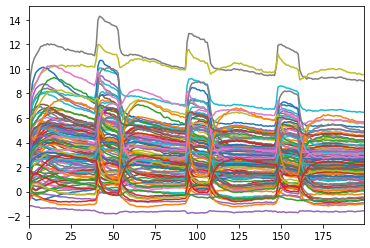

In [22]:
c = []
for l in range(len(dlabels)):
    if (dlabels[l] == -1):
        c.append(l)
row = n.iloc[c]
row.T.plot(legend=False)

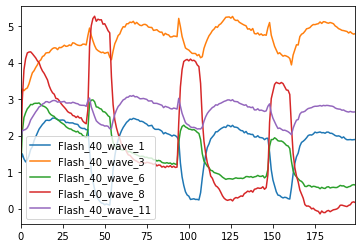

In [25]:
row[:5].T.plot()